In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.02

klin =0

nband = 320

ng =10

ng_refs = (/ 3 , 2 , 5 /) 

nref =3

nv = 50

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 30 , 300 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =300

vstar = 20

data w_diffuse
     &     /1.6 , 1.8 , 1.8 , 1.8,
     &     1.7 , 1.6 , 1.4 , 1.4,
     &     1.7 , 1.8/

data wgt
     &     /0.3 , 0.3 , 0.3 , 0.3,
     &     0.3 , 0.3 , 0.6 , 0.6,
     &     0.6 , 0.6/

atmosphere_profiles/trp75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

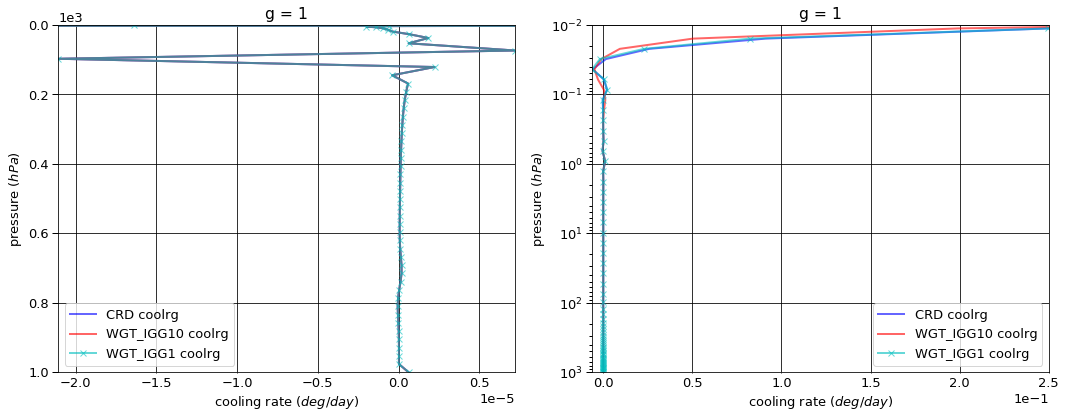

# Figure: cooling rate g-group 2

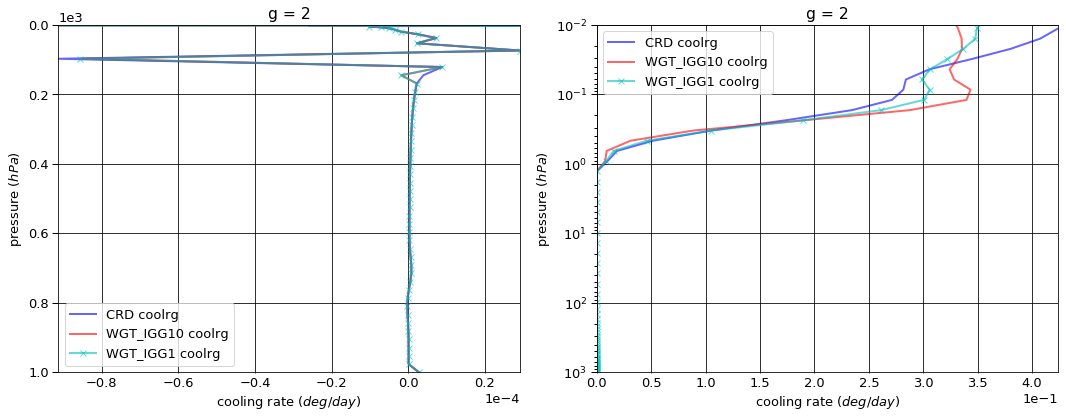

# Figure: cooling rate g-group 3

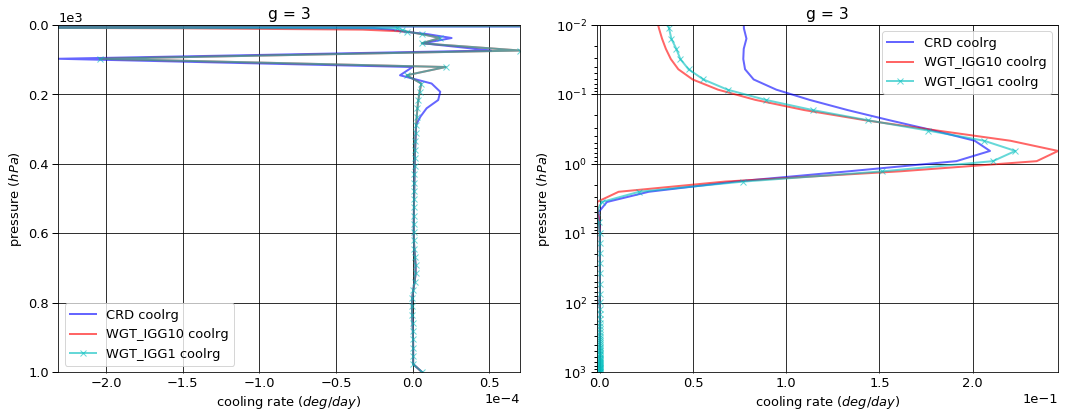

# Figure: cooling rate g-group 4

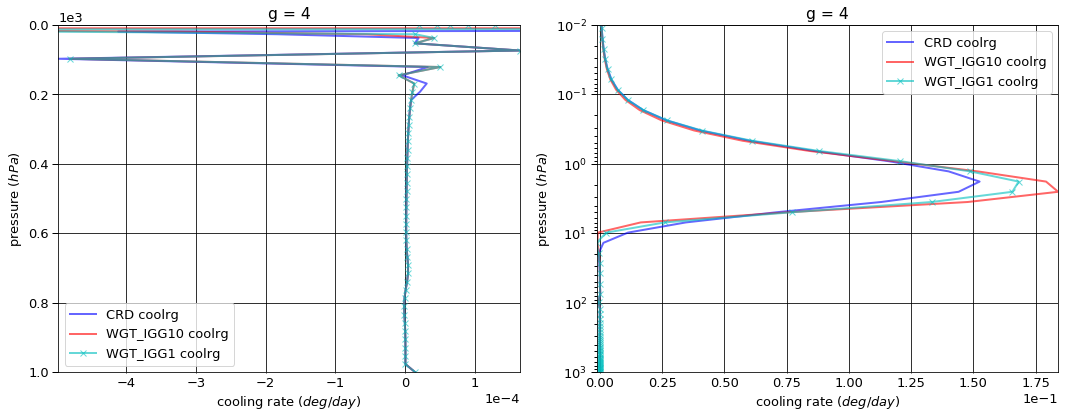

# Figure: cooling rate g-group 5

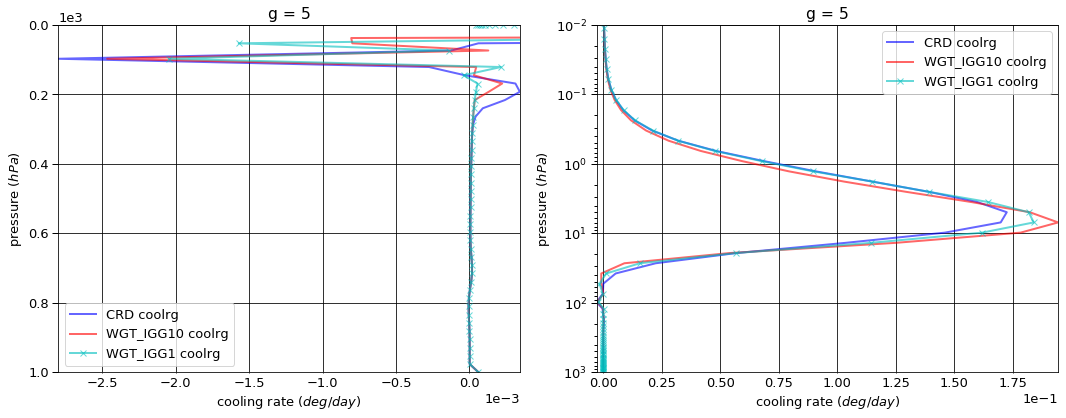

# Figure: cooling rate g-group 6

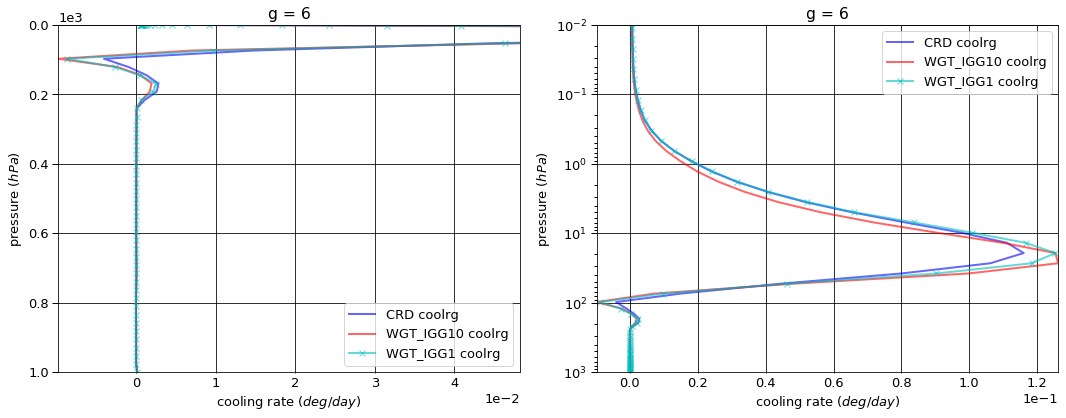

# Figure: cooling rate g-group 7

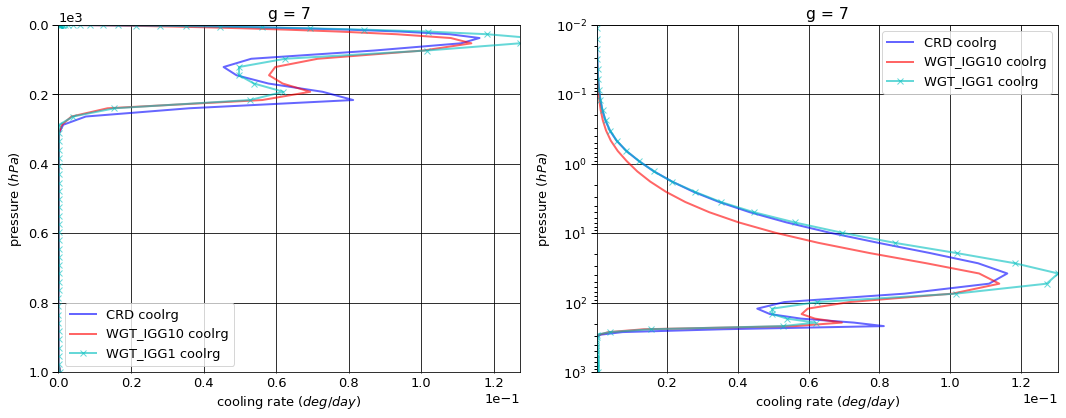

# Figure: cooling rate g-group 8

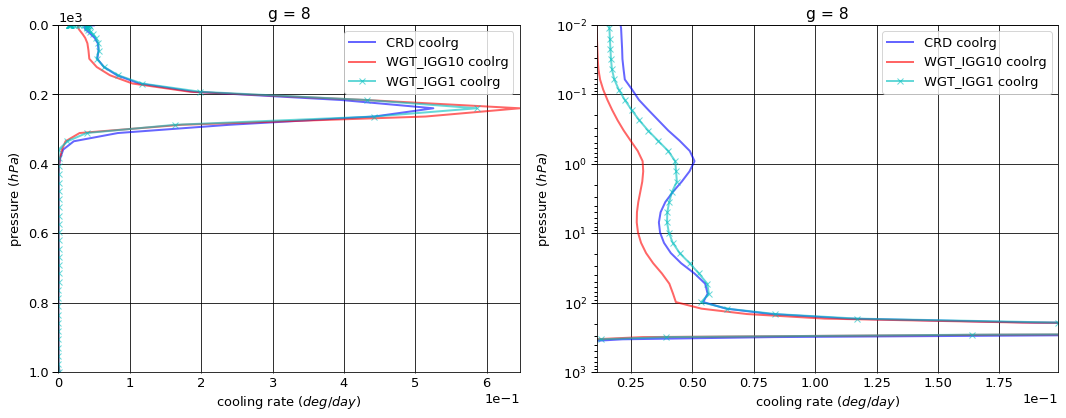

# Figure: cooling rate g-group 9

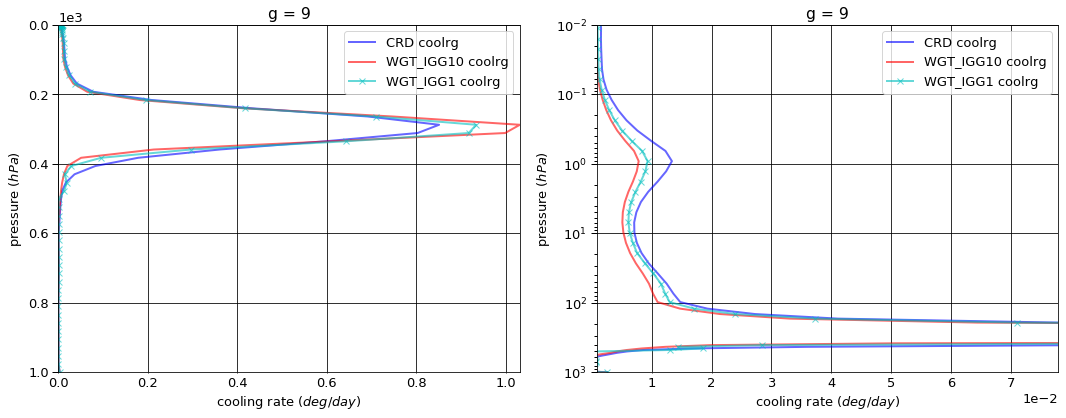

# Figure: cooling rate g-group 10

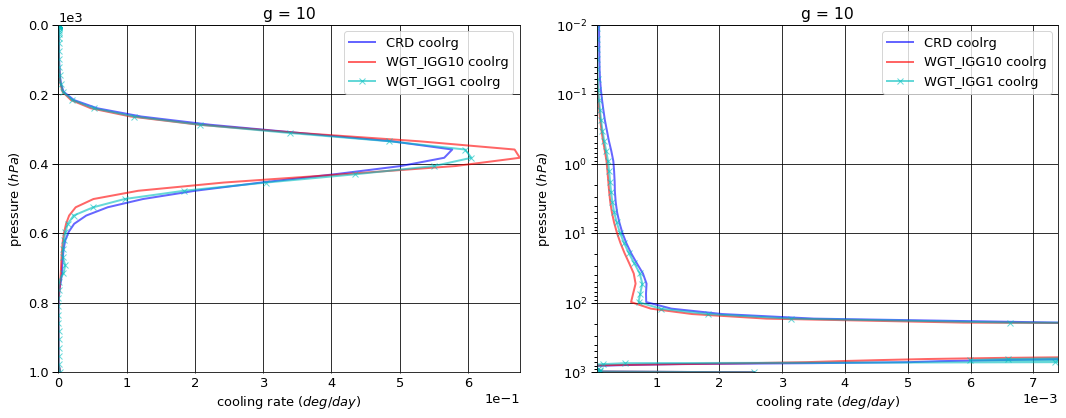

# Figure: cooling rate g-group total

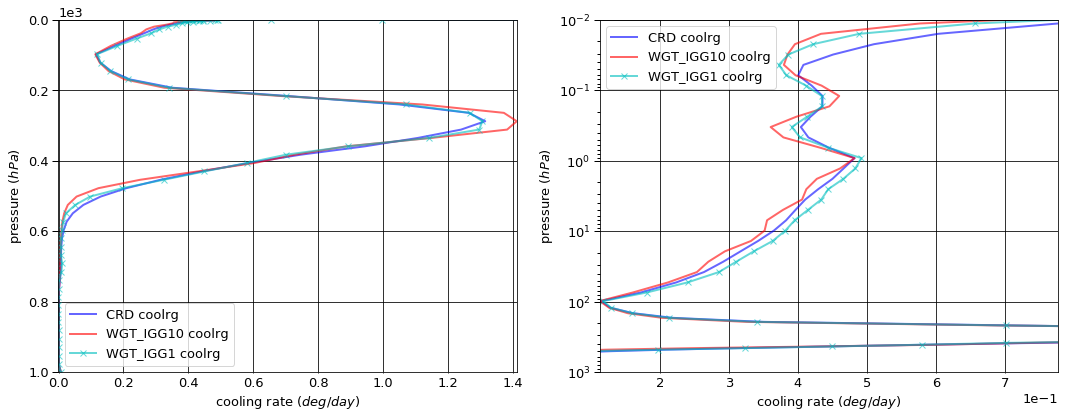

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002858   0.000000  -0.002858
   1013.0   76     -0.005007   0.005005  -0.000002
2  0.0      1      -0.011482   0.000000  -0.011482
   1013.0   76     -0.018909   0.018901  -0.000008
3  0.0      1      -0.036992   0.000000  -0.036992
   1013.0   76     -0.047384   0.047367  -0.000017
4  0.0      1      -0.084826   0.000000  -0.084826
   1013.0   76     -0.112298   0.112258  -0.000040
5  0.0      1      -0.318853   0.000000  -0.318853
   1013.0   76     -0.475751   0.475579  -0.000172
6  0.0      1      -0.618566   0.000000  -0.618566
   1013.0   76     -1.055458   1.055076  -0.000382
7  0.0      1      -2.091982   0.000000  -2.091982
   1013.0   76     -3.828083   3.826689  -0.001394
8  0.0      1      -6.780540   0.000000  -6.780540
   1013.0   76    -11.240439  11.236330  -0.004110
9  0.0      1     -12.699566   0.000000 -12.699566
   1013.0   76    -19.251662  19.244442  -0.007220
10 0.0      1     -11.684579   0.000000 -11.684579
   1013.0   76    -16.829392  16.822300  -0.007092


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002858   0.000000  -0.002858
   1013.0   76     -0.005007   0.005005  -0.000002
2  0.0      1      -0.011444   0.000000  -0.011444
   1013.0   76     -0.018909   0.018901  -0.000008
3  0.0      1      -0.037628   0.000000  -0.037628
   1013.0   76     -0.047384   0.047367  -0.000017
4  0.0      1      -0.086322   0.000000  -0.086322
   1013.0   76     -0.112298   0.112258  -0.000040
5  0.0      1      -0.321837   0.000000  -0.321837
   1013.0   76     -0.475751   0.475579  -0.000172
6  0.0      1      -0.624352   0.000000  -0.624352
   1013.0   76     -1.055458   1.055076  -0.000382
7  0.0      1      -2.043633   0.000000  -2.043633
   1013.0   76     -3.828083   3.826690  -0.001394
8  0.0      1      -6.786563   0.000000  -6.786563
   1013.0   76    -11.240439  11.236330  -0.004110
9  0.0      1     -12.630145   0.000000 -12.630145
   1013.0   76    -19.251662  19.244442  -0.007220
10 0.0      1     -11.603602   0.000000 -11.603602
   1013.0   76    -16.829392  16.822309  -0.007083


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.002858   0.000000  -0.002858
   1013.0   76     -0.005007   0.005005  -0.000002
2  0.0      1      -0.011584   0.000000  -0.011584
   1013.0   76     -0.018909   0.018901  -0.000008
3  0.0      1      -0.037506   0.000000  -0.037506
   1013.0   76     -0.047384   0.047367  -0.000017
4  0.0      1      -0.085851   0.000000  -0.085851
   1013.0   76     -0.112298   0.112258  -0.000040
5  0.0      1      -0.321226   0.000000  -0.321226
   1013.0   76     -0.475751   0.475579  -0.000172
6  0.0      1      -0.625321   0.000000  -0.625321
   1013.0   76     -1.055458   1.055076  -0.000382
7  0.0      1      -2.057871   0.000000  -2.057871
   1013.0   76     -3.828083   3.826690  -0.001394
8  0.0      1      -6.720505   0.000000  -6.720505
   1013.0   76    -11.240439  11.236330  -0.004110
9  0.0      1     -12.644959   0.000000 -12.644959
   1013.0   76    -19.251662  19.244442  -0.007220
10 0.0      1     -11.666547   0.000000 -11.666547
   1013.0   76    -16.829392  16.822309  -0.007083


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -5.730000e-07  0.000000e+00 -5.730000e-07
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1      3.785500e-05  0.000000e+00  3.785500e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -6.359820e-04  0.000000e+00 -6.359820e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.495704e-03  0.000000e+00 -1.495704e-03
   1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
5  0.0      1     -2.984020e-03  0.000000e+00 -2.984020e-03
   1013.0   76    -5.551115e-17  0.000000e+00  0.000000e+00
6  0.0      1     -5.785720e-03  0.000000e+00 -5.785720e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      4.834880e-02  0.000000e+00  4.834880e-02
   1013.0   76    -4.440892e-16  4.440892e-16  0.000000e+00
8  0.0      1     -6.023300e-03  0.000000e+00 -6.023300e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      6.942100e-02  0.000000e+00  6.942100e-02
   1013.0   76     0.000000e+00  3.552714e-15  8.673617e-19
10 0.0      1      8.097700e-02  0.000000e+00  8.097700e-02
   1013.0   76     0.000000e+00  9.000000e-06  9.031400e-06


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -7.187000e-07  0.000000e+00 -7.187000e-07
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2  0.0      1     -1.021200e-04  0.000000e+00 -1.021200e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
3  0.0      1     -5.142950e-04  0.000000e+00 -5.142950e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1     -1.024493e-03  0.000000e+00 -1.024493e-03
   1013.0   76     0.000000e+00  0.000000e+00 -6.776264e-21
5  0.0      1     -2.372080e-03  0.000000e+00 -2.372080e-03
   1013.0   76    -5.551115e-17  0.000000e+00  0.000000e+00
6  0.0      1     -6.754080e-03  0.000000e+00 -6.754080e-03
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      3.411080e-02  0.000000e+00  3.411080e-02
   1013.0   76    -4.440892e-16  4.440892e-16  0.000000e+00
8  0.0      1      6.003560e-02  0.000000e+00  6.003560e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
9  0.0      1      5.460700e-02  0.000000e+00  5.460700e-02
   1013.0   76     0.000000e+00  3.552714e-15  8.673617e-19
10 0.0      1      1.803200e-02  0.000000e+00  1.803200e-02
   1013.0   76     0.000000e+00  9.000000e-06  9.031400e-06

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      9.314370e+00
   1001.112500 75     6.194011e-07
2  0.000312    1      4.246647e-01
   1001.112500 75     2.769509e-06
3  0.000312    1      6.876876e-02
   1001.112500 75     6.198087e-06
4  0.000312    1      2.005877e-05
   1001.112500 75     1.455711e-05
5  0.000312    1      4.596270e-05
   1001.112500 75     6.206327e-05
6  0.000312    1      5.769215e-04
   1001.112500 75     1.374166e-04
7  0.000312    1      1.636928e-04
   1001.112500 75     5.018707e-04
8  0.000312    1      1.756850e-02
   1001.112500 75     1.480085e-03
9  0.000312    1      1.165322e-03
   1001.112500 75     2.599980e-03
10 0.000312    1      6.944091e-05
   1001.112500 75     2.553942e-03


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      7.296929e+00
   1001.112500 75     6.194011e-07
2  0.000312    1      2.754179e-01
   1001.112500 75     2.769509e-06
3  0.000312    1      2.427501e-02
   1001.112500 75     6.198087e-06
4  0.000312    1      1.817712e-05
   1001.112500 75     1.455711e-05
5  0.000312    1      4.255583e-05
   1001.112500 75     6.206327e-05
6  0.000312    1      4.659978e-04
   1001.112500 75     1.374166e-04
7  0.000312    1      1.163214e-04
   1001.112500 75     5.018707e-04
8  0.000312    1      9.848765e-03
   1001.112500 75     1.480085e-03
9  0.000312    1      6.437762e-04
   1001.112500 75     2.599980e-03
10 0.000312    1      3.558383e-05
   1001.112500 75     2.549749e-03


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      8.121968e+00
   1001.112500 75     6.194011e-07
2  0.000312    1      3.037138e-01
   1001.112500 75     2.769509e-06
3  0.000312    1      2.889587e-02
   1001.112500 75     6.198087e-06
4  0.000312    1      1.969702e-05
   1001.112500 75     1.455711e-05
5  0.000312    1      4.758501e-05
   1001.112500 75     6.206327e-05
6  0.000312    1      5.548051e-04
   1001.112500 75     1.374166e-04
7  0.000312    1      1.609124e-04
   1001.112500 75     5.018707e-04
8  0.000312    1      1.455077e-02
   1001.112500 75     1.480085e-03
9  0.000312    1      7.842498e-04
   1001.112500 75     2.599980e-03
10 0.000312    1      4.134395e-05
   1001.112500 75     2.549749e-03


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -2.017441e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.492468e-01
   1001.112500 75     4.235165e-22
3  0.000312    1     -4.449374e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.881648e-06
   1001.112500 75     0.000000e+00
5  0.000312    1     -3.406877e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.109237e-04
   1001.112500 75     0.000000e+00
7  0.000312    1     -4.737144e-05
   1001.112500 75     0.000000e+00
8  0.000312    1     -7.719737e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -5.215460e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -3.385708e-05
   1001.112500 75    -4.192300e-06


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -1.192402e+00
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.209509e-01
   1001.112500 75     4.235165e-22
3  0.000312    1     -3.987289e-02
   1001.112500 75     0.000000e+00
4  0.000312    1     -3.617460e-07
   1001.112500 75     0.000000e+00
5  0.000312    1      1.622307e-06
   1001.112500 75     0.000000e+00
6  0.000312    1     -2.211638e-05
   1001.112500 75     0.000000e+00
7  0.000312    1     -2.780460e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.017736e-03
   1001.112500 75     0.000000e+00
9  0.000312    1     -3.810724e-04
   1001.112500 75     0.000000e+00
10 0.000312    1     -2.809696e-05
   1001.112500 75    -4.192300e-06

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.330244,0.000000,-34.330244
1013.0,76,-52.864383,52.843948,-0.020437



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.148385,0.000000,-34.148385
1013.0,76,-52.864383,52.843957,-0.020428



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-34.174226,0.000000,-34.174226
1013.0,76,-52.864383,52.843957,-0.020428



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.181859,0.000000,0.181859
1013.0,76,0.000000,0.000009,0.000009



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.156018,0.000000,0.156018
1013.0,76,0.000000,0.000009,0.000009


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,9.827414
1001.112500,75,0.007360



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,7.607793
1001.112500,75,0.007355



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,8.470737
1001.112500,75,0.007355



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-2.219620
1001.112500,75,-0.000004



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-1.356676
1001.112500,75,-0.000004


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000098
2,0.000313,0.000351
3,0.001000,0.000915
4,0.002687,0.002176
5,0.011000,0.009197
6,0.023375,0.020414
7,0.088188,0.073902
8,0.250437,0.216633
9,0.391250,0.367904


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.372307e-16
2,2.601420e-17
3,2.852660e-18
4,5.740151e-18
5,6.832022e-19
6,7.155529e-19
7,8.793590e-20
8,1.080664e-20
9,1.328052e-21


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.372307e-16,NaN,0.000125,0.000098,0.000125,0.000098,1.0
2,2.601420e-17,0.109658,0.000313,0.000351,0.000438,0.000450,1.0
3,2.852660e-18,0.109658,0.001000,0.000915,0.001437,0.001364,1.0
4,5.740151e-18,2.012210,0.002687,0.002176,0.004125,0.003541,30.0
5,6.832022e-19,0.119022,0.011000,0.009197,0.015125,0.012738,30.0
6,7.155529e-19,1.047351,0.023375,0.020414,0.038500,0.033152,300.0
7,8.793590e-20,0.122892,0.088188,0.073902,0.126688,0.107054,300.0
8,1.080664e-20,0.122892,0.250437,0.216633,0.377125,0.323686,300.0
9,1.328052e-21,0.122892,0.391250,0.367904,0.768375,0.691590,300.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [27]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.439018e-15  1.767005e-15   1.380312  1.362148e-01
      2  0.000312     2.897163e-17  1.934118e-17   1.497925  1.538192e-03
      3  0.000312     2.124393e-18  5.932142e-19   3.581157  7.283079e-05
      4  0.000312     2.985599e-22  2.985545e-22   1.000018  2.065813e-08
      5  0.000312     1.381695e-22  1.371164e-22   1.007680  9.509415e-09
      6  0.000312     6.633037e-22  5.665561e-22   1.170764  4.121025e-08
      7  0.000312     4.578161e-23  3.712280e-23   1.233248  2.928134e-09
      8  0.000312     2.307085e-21  6.339127e-23  36.394371  9.753560e-08
      9  0.000312     8.394761e-23  4.632089e-24  18.123055  3.613378e-09
      10 0.000312     7.401213e-24  3.206509e-25  23.081841  3.161440e-10
2     1  0.000750     2.435584e-15  1.767069e-15   1.378318  5.483805e-02
      2  0.000750     2.919985e-17  1.948329e-17   1.498712  6.242437e-04
      3  0.000750     2.134455e-18  5.975642e-19   3.571927  2.950426e-05
      4  0.000750     6.826284e-22  6.826007e-22   1.000041  1.902444e-08
      5  0.000750     1.750696e-22  1.739669e-22   1.006339  4.857709e-09
      6  0.000750     6.688345e-22  5.715898e-22   1.170130  1.674339e-08
      7  0.000750     4.662447e-23  3.791722e-23   1.229639  1.202364e-09
      8  0.000750     2.308810e-21  6.358609e-23  36.309990  3.931705e-08
      9  0.000750     8.458430e-23  4.659529e-24  18.152970  1.466373e-09
      10 0.000750     7.406088e-24  3.225172e-25  22.963390  1.274409e-10
3     1  0.001052     2.429057e-15  1.767346e-15   1.374409  7.683514e-02
      2  0.001052     2.962876e-17  1.969986e-17   1.504009  8.863847e-04
      3  0.001052     2.149900e-18  6.014132e-19   3.574747  4.166276e-05
      4  0.001052     9.470545e-22  9.470015e-22   1.000056  3.701395e-08
      5  0.001052     2.026640e-22  2.014820e-22   1.005867  7.888735e-09
      6  0.001052     6.752049e-22  5.769416e-22   1.170318  2.370180e-08
      7  0.001052     4.739860e-23  3.859404e-23   1.228133  1.714913e-09
      8  0.001052     2.312280e-21  6.381446e-23  36.234424  5.522262e-08
      9  0.001052     8.586079e-23  4.700327e-24  18.266982  2.086993e-09
      10 0.001052     7.415710e-24  3.251474e-25  22.807221  1.789881e-10
4     1  0.001476     2.422369e-15  1.767554e-15   1.370464  1.076894e-01
      2  0.001476     3.007468e-17  1.993382e-17   1.508726  1.259817e-03
      3  0.001476     2.166601e-18  6.063178e-19   3.573375  5.891132e-05
      4  0.001476     1.317521e-21  1.317418e-21   1.000078  7.223796e-08
      5  0.001476     2.402987e-22  2.390234e-22   1.005335  1.312704e-08
      6  0.001476     6.826420e-22  5.833446e-22   1.170221  3.361917e-08
      7  0.001476     4.837085e-23  3.946667e-23   1.225613  2.456963e-09
      8  0.001476     2.315832e-21  6.407934e-23  36.140069  7.759402e-08
      9  0.001476     8.718588e-23  4.745002e-24  18.374256  2.972400e-09
      10 0.001476     7.425496e-24  3.280780e-25  22.633328  2.514871e-10
5     1  0.002070     2.415571e-15  1.767673e-15   1.366526  1.508933e-01
      2  0.002070     3.053497e-17  2.018880e-17   1.512471  1.791349e-03
      3  0.002070     2.184798e-18  6.126796e-19   3.565972  8.339057e-05
      4  0.002070     1.836621e-21  1.836423e-21   1.000108  1.412369e-07
      5  0.002070     2.919467e-22  2.905587e-22   1.004777  2.237779e-08
      6  0.002070     6.914993e-22  5.911674e-22   1.169718  4.777929e-08
      7  0.002070     4.961530e-23  4.061002e-23   1.221750  3.538700e-09
      8  0.002070     2.319422e-21  6.439237e-23  36.020139  1.090076e-07
      9  0.002070     8.854538e-23  4.794378e-24  18.468587  4.233301e-09
      10 0.002070     7.435345e-24  3.313842e-25  22.437233  3.532887e-10
6     1  0.002904     2.408617e-15  1.767682e-15   1.362585  2.114393e-01
      2  0.002904     3.101364e-17  2.047325e-17   1.514837  2.549766e-03
      3  0.002904     2.205075e

# Histogram of wavenumbers in g-group 1

In [28]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [29]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
